<a href="https://colab.research.google.com/github/alimogharrebi/Deep_Learning_Projects/blob/main/DetectionofAnomalousConditionsByVisionTransformers_Thursday_2022_07_July_1401_04_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessery packages
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import zipfile
import os
import datetime as dt
import six
import h5py

#Plot Utilities
We will be plotting several graphs in this notebook so it's good to have a utility function for that. The following code will visualize numpy arrays into a graph using Pyplot's plot() method. The x-axis will contain the time steps. The exact unit is not critical so we can pretend it is either seconds, hours, year, etc. The y-axis will contain the measured values at each time step.

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      label (list of strings)- tag for the line
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Plot the time series data
    plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    if label:
      plt.legend(fontsize=14, labels=label)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

#Airbus Helicopter Accelerometer Dataset


The use case is relative to flight test helicopters vibration measurements. The dataset has been collected and released by Airbus SAS. A main challenge in flight tests of heavily instrumented aircraft (helicopters or airplanes alike) is the validation of the generated data because of the number of signals to validate. Manual validation requires too much time and manpower. Automation of this validation is crucial. 
    
In this case, different accelerometers are placed at different positions of the helicopter, in different directions (longitudinal, vertical, lateral) to measure the vibration levels in all operating conditions of the helicopter. The data set consists of multiple 1D time series with a constant frequency of 1024 Hz taken from different flights, cut into 1 minute sequences.

We are interested in the detection of abnormal sensor behaviour. Sensors are recorded at 1024Hz and we provide sequences of one-minute length. 

Training data
The training dataset is composed of 1677 one-minute-sequences @1024Hz of accelerometer data measured on test helicopters at various locations, in various angles (X, Y, Z), on different flights. All data has been multiplied by a factor so that absolute values are meaningless, but no other normalization procedure was carried out. All sequences are considered as normal and should be used to learn normal behaviour of accelerometer data.
Validation Data
The validation dataset is composed of 594 one-minute-sequences of accelerometer data measured on test helicopters at various locations, in various angles (X, Y, Z). Locations and angles may or may not be identical to those of the training dataset. Sequences are to be tested with the normal behaviour learnt from the training data to detect abnormal behaviour. The amount of abnormal sequences in the validation dataset is a priori unknown.

Datasets are provided in a HDF5 format that can be decoded by many standard machine learning modules (like pandas for instance):
  +  In the training dataset, the dataframe is called "dftrain"
  +  In the validation dataset, the dataframe is called "dfvalid"
Each dataframe has 61440 (1024 * 60) columns corresponding all time steps contained in one minute at 1024Hz and are named from 0 to 61339.
Supplementing the paper: G. Garcia, G. Michau, M. Ducoffe, J. Sen Gupta, O. Fink, 2020, Time Series to Images: Monitoring the Condition of Industrial Assets with Deep Learning Image Processing Algorithms, arXiv:2005.07031

In [3]:
# Download and Unzip Data set
#Downloading Airbus Helicopter Accelerometer Dataset
#https://www.research-collection.ethz.ch/handle/20.500.11850/415151
!wget https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/415151/dfvalid.h5 #Dataset with Anomalies
!wget https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/415151/dftrain.h5 #Training Healthy Dataset
!wget https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/415151/dfvalid_groundtruth.csv #Ground Truth for the Dataset with Anomalies


--2022-07-07 11:40:27--  https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/415151/dfvalid.h5
Resolving www.research-collection.ethz.ch (www.research-collection.ethz.ch)... 129.132.8.151
Connecting to www.research-collection.ethz.ch (www.research-collection.ethz.ch)|129.132.8.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 292955936 (279M) [application/x-hdf5]
Saving to: ‘dfvalid.h5’

dfvalid.h5          100%[===================>] 279.38M  12.9MB/s    in 23s     

2022-07-07 11:40:52 (12.0 MB/s) - ‘dfvalid.h5’ saved [292955936/292955936]

--2022-07-07 11:40:52--  https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/415151/dftrain.h5
Resolving www.research-collection.ethz.ch (www.research-collection.ethz.ch)... 129.132.8.151
Connecting to www.research-collection.ethz.ch (www.research-collection.ethz.ch)|129.132.8.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 825280760 (787M) [application/x-

In [4]:
dfvalidFileName = '/content/dfvalid.h5'
dftrainFileName = '/content/dftrain.h5'
modeType   = 'r' #modeType: 'w', 'r+', 'r', or 'a'
dfvalid = h5py.File(dfvalidFileName, modeType)
dftrain = h5py.File(dftrainFileName, modeType)

In [5]:
dfvalidKeyList = list(dfvalid.keys())
dftrainKeyList = list(dftrain.keys())
# print(dfvalidKeyList)
# for key in dfvalid[dfvalidKeyList[0]].keys():
#   print(key)
# group = dfvalid[dfvalidKeyList[0]]
# for key in group.keys():
#   print(key)
# print(dfvalid['dfvalid']['block0_items'].shape)

In [6]:
# dir(dfvalid)
for i in dfvalid['dfvalid'].keys():
  print(i)

axis0
axis1
block0_items
block0_values


In [7]:
#The training dataset: consists of 1677 sequences from normal flights;
train_data = dftrain['dftrain']['block0_values'][()]
#The test (validation) dataset: consists of 594 sequences from both normal and anomalous flights (297 of each)
valid_data = dfvalid['dfvalid']['block0_values'][()] 
print(type(valid_data)) #numpy.ndarray
#The training dataset: consists of 1677 sequences from normal flights
'''
The dataset consists of multiple 1D time series with a constant frequency of 1024 Hz
taken from different flights, cut into 1 minute sequences.
'''
print(f"The shape of training data set is: {train_data.shape}") # (1677, 61440) 61440 = 60 (sec) * 1024 (Htz)
"""
Training data
The training dataset is composed of 1677 one-minute-sequences @1024Hz of accelerometer data measured on test helicopters at various locations, in various angles (X, Y, Z), on different flights. All data has been multiplied by a factor so that absolute values are meaningless, but no other normalization procedure was carried out. All sequences are considered as normal and should be used to learn normal behaviour of accelerometer data.
Validation Data
"""
"""
The validation dataset is composed of 594 one-minute-sequences of accelerometer data 
measured on test helicopters at various locations, in various angles (X, Y, Z). 
Locations and angles may or may not be identical to those of the training dataset. 
Sequences are to be tested with the normal behaviour learnt from the training data to detect abnormal behaviour.
 The amount of abnormal sequences in the validation dataset is a priori unknown.
"""
print(f"The shape of validation dataset is: {valid_data.shape}") 
# print(valid_data)

<class 'numpy.ndarray'>
The shape of training data set is: (1677, 61440)
The shape of validation dataset is: (594, 61440)


In [8]:
# type(dftrain)
# for key in dftrain['dftrain'].keys():
#   print(key)
# axis0
# axis1
# block0_items
# block0_values
# a = dftrain['dftrain']['block0_items']
# a.shape
# dir(dftrain['dftrain']['block0_items'])
# dftrain['dftrain']['block0_items'].ndim
# dftrain['dftrain']['block0_items'].size

In [9]:
# Reading the Ground Truth for the Dataset with Anomalies
dfvalid_groundtruth = pd.read_csv('/content/dfvalid_groundtruth.csv')
print(dfvalid_groundtruth.shape) #consists of 594 sequences from both normal and anomalous flights
print(dfvalid_groundtruth) #[594 rows x 2 columns (seqID,anomaly)]
# dfvalid_groundtruth['anomaly']

(594, 2)
     seqID  anomaly
0        0      0.0
1        1      1.0
2        2      0.0
3        3      0.0
4        4      1.0
..     ...      ...
589    589      1.0
590    590      1.0
591    591      0.0
592    592      0.0
593    593      1.0

[594 rows x 2 columns]


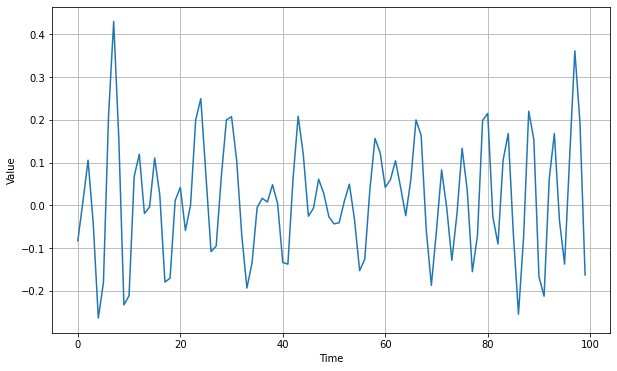

In [10]:
# Time series segments contains 1024*60 points. Given that the sampling frequency is 1024Hz each time serie covers 60 seconds.
# This is an example of a signal data visualization
# import matplotlib.pyplot as plt
# import plotly.express as px 
%matplotlib inline
id = 50 #Some random id for signal visualization
number_of_samples = 1024*60
x = list(range(number_of_samples))
y = list(valid_data[id,:])
plot_series(x[:100],y[:100])
# Set figure
# plt.figure(figsize=(12,10))
# Plotly graph
# plot = px.line(x=x, y=y)
# Setting Ticks
# plt.tick_params(axis='x',labelsize=15,rotation=90)
# plt.tight_layout()
# Display
# plot.show()


Text(0.5, 1.0, 'Illustration of Vibration Signals in Validation Dataset (1-6) for first 1000 sample')

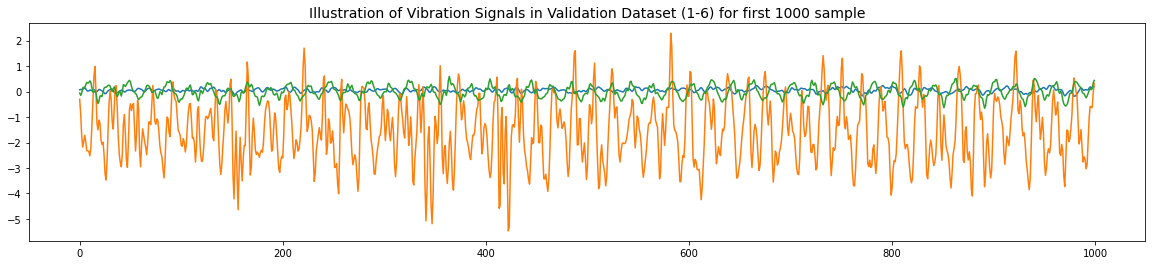

In [12]:
plt.figure(figsize=(20,4))
for i in range(0,3):
      plt.plot(valid_data[i,:1000])
      # plot_series([x for x in range(1000)],valid_data[i,:1000])
plt.title("Illustration of Vibration Signals in Validation Dataset (1-6) for first 1000 sample", fontsize=14)


Text(0.5, 1.0, 'Distribution of measurements')

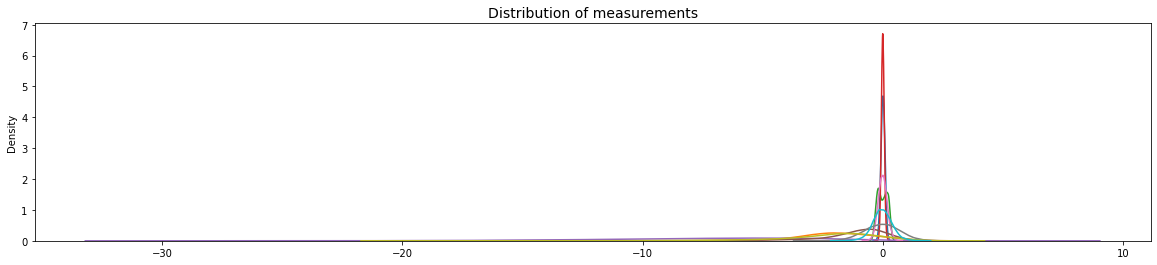

In [13]:
plt.figure(figsize=(20,4))
for i in range(0,10):
     sns.kdeplot(valid_data[i])
plt.title("Distribution of measurements", fontsize=14)

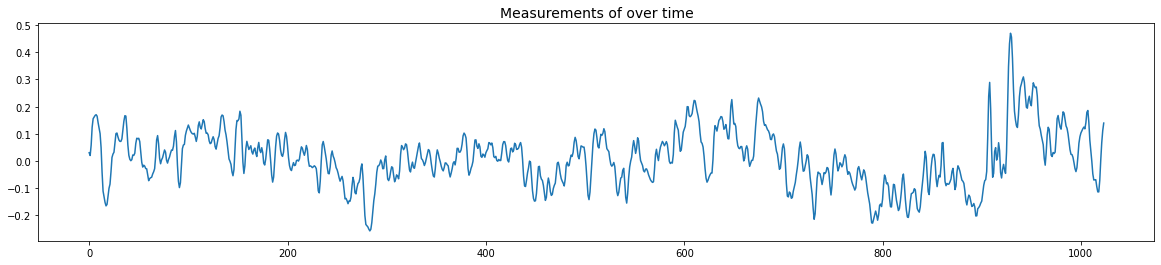

In [ ]:
plt.figure(figsize=(20,4))
plt.plot(valid_data[3,:1024])
plt.title("Measurements of over time", fontsize=14);

In [53]:
def signal_to_image(series_value, samplingFrequency=1024, show = True):
  from IPython.core.pylabtools import figsize
  # Imaging signal data
  import matplotlib.pyplot as plot
  # samplingFrequency = 1024 #Sampling Frequency
  plot.axis('off')
  # plot.subplot(784)
  spectrum, freqs, t, im = plot.specgram(series_value,Fs=samplingFrequency)
  plot.xlabel('Time')
  plot.ylabel('Frequency')
  # my_dpi = 96
  # img = plot.savefig(fname='test',figsize=(224/my_dpi,224/my_dpi), dpi = my_dpi)
  # plot.colorbar()
  if show:
    plot.show()
  
  return im
def save_signal_image(signal_image, save_dir, file_name, dpi_):
  """
  Tis function saves the signal_image to save_dir with file_name
  Args:
    signal_image (matplotlib.figure.Figure instance): A spectrogram image
    save_dir (String): A directory address for saving the image
    file_name (String): A name for file that is saving
  Return:
  """
  import matplotlib.pyplot as plot
  import os
  file_name = os.path.join(save_dir,file_name)
  signal_image.figure.savefig (fname=file_name, figsize=(224/dpi_,224/dpi_), dpi = dpi_)


In [ ]:
# my_signal_image = signal_to_image(valid_data[3])
# save_signal_image(my_signal_image, "/content/validation_signals_pictures","test_image", dpi_=96)
# my_signal_image.figure


In [ ]:
# This is another way for converting a signal to image representation
# Import libraries 
# import numpy as np 
# from scipy import signal 
# import matplotlib as mpl 
# import matplotlib.pyplot as plt 
# import requests  # pip install requests 
# %matplotlib inline 
# mpl.rcParams['figure.figsize'] = [12, 8] 
 
 
# # Get some data 
# # r = requests.get('https://forums.ni.com/ni/attachments/ni/170/322886/1/ecg.txt') 
# # if r.status_code == 200: 
# #     data = r.text 
# #     data = np.array([float(el) for el in data.splitlines()])  
# # else: 
# #     print("Couldn't load data!") 
 
 
# # Plot spectrogram 
# fig, ax = plt.subplots()
# y = np.array(y)  
# f, t, Sxx = signal.spectrogram(y) 
# pc = ax.pcolormesh(t, f, Sxx, norm=mpl.colors.LogNorm(vmin=Sxx.min(), vmax=Sxx.max()), cmap='inferno') 
# ax.set_ylabel('Frequency') 
# ax.set_xlabel('Time')  
# fig.colorbar(pc) 

# Converting All training signals to images

In [61]:
# Making directories for saving images
import os
root_image_directory = "./signal_images"
train_signal_images_directory = "./signal_images/train_signal_images"
val_signal_images_directory = "./signal_images/val_signal_images"
os.makedirs(root_image_directory,exist_ok=True)
os.makedirs(train_signal_images_directory,exist_ok=True)
os.makedirs(val_signal_images_directory,exist_ok=True)

Vision Transformer Section

In [ ]:
%%capture
!pip install timm

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model

# Prepare Model and Data

The Vision Transformer (ViT) is a transformer encoder model (BERT-like) pretrained on a large collection of images in a supervised fashion, namely ImageNet-21k, at a resolution of 224x224 pixels. 

In [ ]:
model_name = "vit_base_patch16_224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
model = create_model(model_name, pretrained=True).to(device)

device =  cpu


In [ ]:
# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)


In [ ]:
%%capture
# ImageNet Labels
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

# Demo Image
!wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

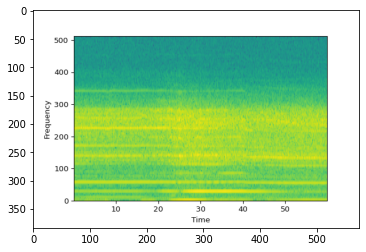

In [ ]:
# Importing Image and ImageOps module from PIL package
from PIL import ImageOps
img = PIL.Image.open('/content/test.png')
plt.imshow(img)


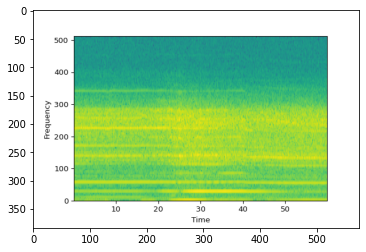

In [ ]:
img = PIL.Image.open('/content/test.png')
# img_tensor = transforms(img).unsqueeze(0).to(device)
plt.imshow(img)

In [ ]:
img = PIL.Image.open('/content/test.png')
img = img.convert('RGB')
img = img.resize((224,224))
img_tensor = transforms(img).unsqueeze(0).to(device)
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [ ]:
print("image size",img.size,"image shape", img_tensor.shape)

image size (224, 224) image shape torch.Size([1, 3, 224, 224])


# Simple Inference

In [ ]:
# end-to-end inference
output = model(img_tensor)

In [ ]:
print(imagenet_labels[int(torch.argmax(output))])

web_site, website, internet_site, site



Inference Result:
web_site, website, internet_site, site



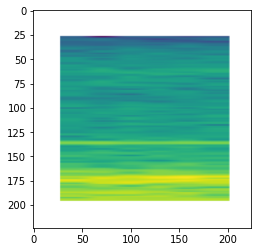

In [ ]:
print("Inference Result:")
print(imagenet_labels[int(torch.argmax(output))])
plt.imshow(img)

# Dig into Vision Transformer

Let's look at the details of the Vision Transformer!


<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/vit_input.png?raw=true'>

Figure 1. Vision Transformer inference pipeline.  
1. Split Image into Patches  
The input image is split into 14 x 14 vectors with dimension of 768 by Conv2d (k=16x16) with stride=(16, 16). 
2. Add Position Embeddings  
Learnable position embedding vectors are added to the patch embedding vectors and fed to the transformer encoder. 
3. Transformer Encoder  
The embedding vectors are encoded by the transformer encoder. The dimension of input and output vectors are the same. Details of the encoder are depicted in Fig. 2.
4. MLP (Classification) Head  
The 0th output from the encoder is fed to the MLP head for classification to output the final classification results.


# 1. Split Image into Patches

The input image is split into N patches (N = 14 x 14 for ViT-Base)
and converted to D=768 embedding vectors by learnable 2D convolution:
```
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
```

In [ ]:
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])


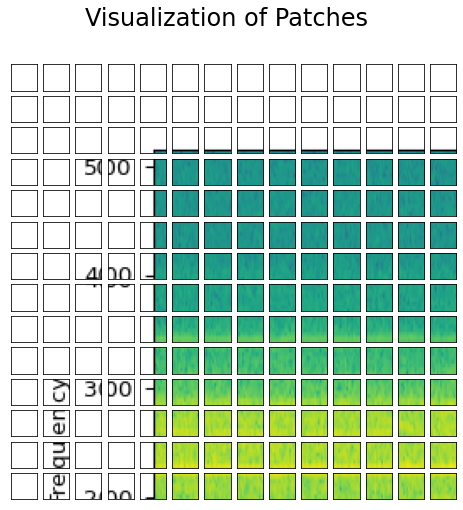

In [ ]:
# This is NOT a part of the pipeline.
# Actually the image is divided into patch embeddings by Conv2d 
# with stride=(16, 16) shown above.
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of Patches", fontsize=24)
fig.add_axes()
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

In [ ]:
patch.shape

(16, 16, 3)

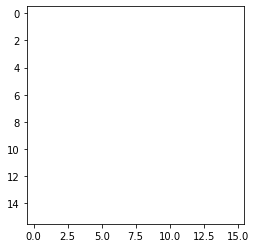

In [ ]:
plt.imshow(patch)

In [ ]:
img.shape

(224, 224, 3)

# 2. Add Position Embeddings
To make patches position-aware, learnable 'position embedding' vectors are added to the patch embedding vectors. The position embedding vectors learn distance within the image thus neighboring ones have high similarity.

### Visualization of position embeddings

In [ ]:
pos_embed = model.pos_embed
print(pos_embed.shape)

torch.Size([1, 197, 768])


In [ ]:
print(pos_embed[0][:][:].shape)

torch.Size([197, 768])


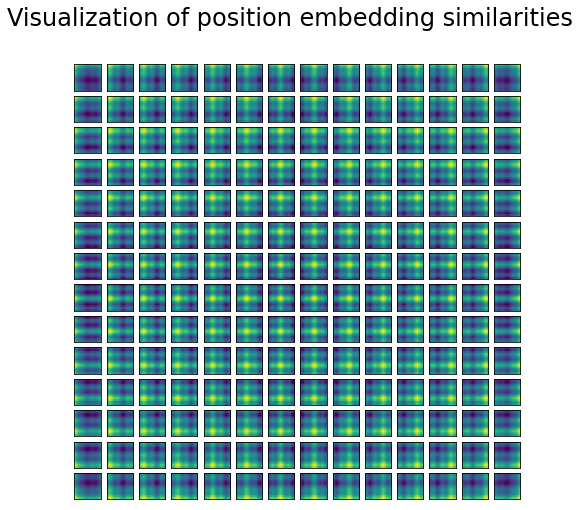

In [ ]:
# Visualize position embedding similarities.
# One cell shows cos similarity between an embedding and all the other embeddings.
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

### Make Transformer Input
A learnable class token is prepended to the patch embedding vectors as the 0th vector.  
197 (1 + 14 x 14) learnable position embedding vectors are added to the patch embedding vectors.

In [ ]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

Transformer input:  torch.Size([1, 197, 768])


# 3. Transformer Encoder
<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/transformer_encoder.png?raw=true'>

Figure 2. Detailed schematic of Transformer Encoder. 
- N (=197) embedded vectors are fed to the L (=12) series encoders. 
- The vectors are divided into query, key and value after expanded by an fc layer. 
- q, k and v are further divided into H (=12) and fed to the parallel attention heads. 
- Outputs from attention heads are concatenated to form the vectors whose shape is the same as the encoder input.
- The vectors go through an fc, a layer norm and an MLP block that has two fc layers.

The Vision Transformer employs the Transformer Encoder that was proposed in the [attention is all you need paper](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). 

Implementation Reference: 

- [tensorflow implementation](https://github.com/google-research/vision_transformer/blob/502746cb287a107f9911c061f9d9c2c0159c81cc/vit_jax/models.py#L62-L146)
- [pytorch implementation (timm)](https://github.com/rwightman/pytorch-image-models/blob/198f6ea0f3dae13f041f3ea5880dd79089b60d61/timm/models/vision_transformer.py#L79-L143)


### Series Transformer Encoders

In [ ]:
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

Input tensor to Transformer (z0):  torch.Size([1, 197, 768])
Entering the Transformer Encoder 0
Entering the Transformer Encoder 1
Entering the Transformer Encoder 2
Entering the Transformer Encoder 3
Entering the Transformer Encoder 4
Entering the Transformer Encoder 5
Entering the Transformer Encoder 6
Entering the Transformer Encoder 7
Entering the Transformer Encoder 8
Entering the Transformer Encoder 9
Entering the Transformer Encoder 10
Entering the Transformer Encoder 11
Output vector from Transformer (z12-0): torch.Size([1, 768])


## How Attention Works

In this part, we are going to see what the actual attention looks like.

In [ ]:
print("Transformer Multi-head Attention block:")
attention = model.blocks[0].attn
print(attention)
print("input of the transformer encoder:", transformer_input.shape)

Transformer Multi-head Attention block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
input of the transformer encoder: torch.Size([1, 197, 768])


In [ ]:
# fc layer to expand the dimension
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("expanded to: ", transformer_input_expanded.shape)

expanded to:  torch.Size([197, 2304])


In [ ]:
# Split qkv into mulitple q, k, and v vectors for multi-head attantion
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)

split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


attention matrix:  torch.Size([12, 197, 197])


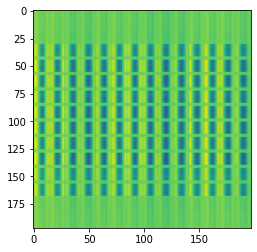

In [ ]:
# Attention Matrix
attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

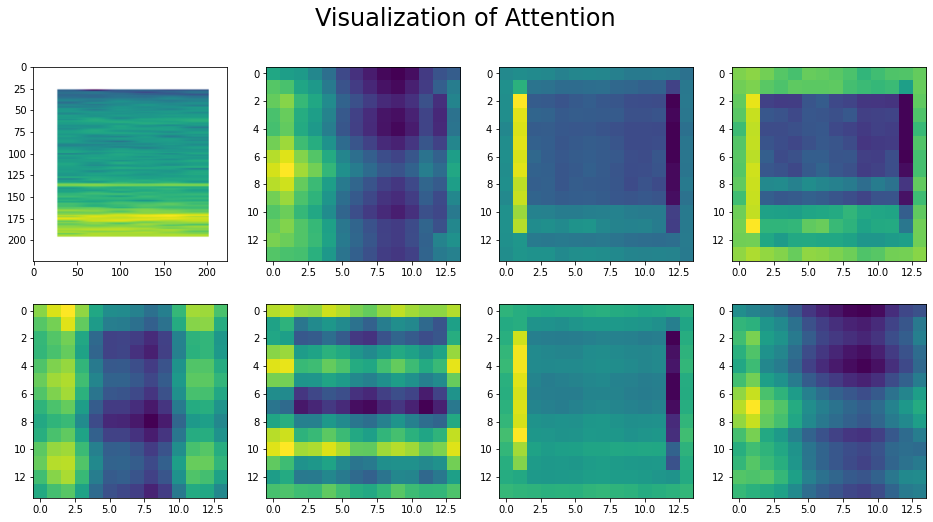

In [ ]:
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention", fontsize=24)
fig.add_axes()
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

# 4. MLP (Classification) Head
The 0-th output vector from the transformer output vectors (corresponding to the class token input) is fed to the MLP head.  
The 1000-dimension classification result is the output of the whole pipeline.

Classification head:  Linear(in_features=768, out_features=1000, bias=True)
Inference result : id = 916, label name = web_site, website, internet_site, site



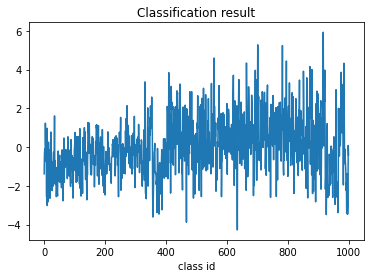

In [ ]:
print("Classification head: ", model.head)
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
print("Inference result : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]))

In [ ]:
B021 = pd.read_csv("/content/cwru-bearing-datasets/raw/B021_1_227.mat.csv")
print(f"The Shape of B021 file is {B021.shape}")
type(B021)

The Shape of B021 file is (486804, 4)


pandas.core.frame.DataFrame

In [ ]:
B021.head()

,Unnamed: 0,X227_DE_time,X227_FE_time,X227RPM
0,0,-0.061959,0.124711,1774.0
1,1,-0.037551,0.116698,NaN
2,2,-0.017941,0.081155,NaN
3,3,0.019401,0.001849,NaN
4,4,0.049650,-0.058555,NaN
